In [3]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from Data.data_retrieval import get_data
from Utils.add_features import add_fisher
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import time
from datetime import timedelta
from datetime import date, datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
import os

In [16]:
class StockTradingEnv(gym.Env):

    def __init__(self, df, features, init_account_balance, window_shape, random_start=False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        self.signal_features = features

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        self.signal_features = self.signal_features.iloc[self.start:self.end]
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step - self.window_shape:self.current_step]

        print(f"Market state: {market_state}")

        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.current_step >= (len(self.df) - self.window_shape)):  # (self.net_worth <= 0) or
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = self.df.iloc[self.current_step]["Close"]
        self.current_price = current_price
        self.datetime = self.df.index[self.current_step]


        print("*"*100)
        print(f"Curruent step: {self.current_step}")
        print(f"df.iloc[self.current_step]: {df.iloc[self.current_step]}")
        print(f"Datetime: {self.datetime}")


        if not self.in_position:
            if action == 1:  # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else:  # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1:  # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else:  # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'price': self.current_price,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance,
            'datetime': self.datetime
        }

def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': [],
        'price': [],
        'datetime': []
    }

    for i in range(len(df) - HISTORICAL_STATES):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action[0])
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])
        history['price'].append(state['price'])
        history['datetime'].append(state['datetime'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

In [17]:
TICKER = ".NSEI"
INIT_NET_WORTH = 10000
HISTORICAL_STATES = 5
features = [
    {"feature": "Fisher20", "lookback": 20},
    {"feature": "Fisher5", "lookback": 5},
]
LR = 0.001
RANDOM_SEED = 11111
WINDOW = max([feature["lookback"] for feature in features])
train_percent = 0.8

df = get_data(TICKER, 'D').set_index('Datetime')

In [18]:
signal_features = pd.DataFrame(index=df.index)
for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
    if feature == "Close":
        signal_features[feature] = df["Close"]
    if feature.startswith("Fisher"):
        signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]

train_df = df.iloc[:int(train_percent * len(df))]
test_df = df.iloc[int(train_percent * len(df)):]
train_signal_features = signal_features.iloc[:int(train_percent * len(signal_features))]
test_signal_features = signal_features.iloc[int(train_percent * len(signal_features)):]

N_TIME_STEPS = len(train_df) - HISTORICAL_STATES

In [19]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv(
    [lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

Using cpu device
Market state:             Fisher20   Fisher5
Datetime                      
2007-09-24       0.0  0.791374
2007-09-25       0.0  1.261493
2007-09-26       0.0  1.725175
2007-09-27       0.0  2.175409
2007-09-28       0.0  2.612569
****************************************************************************************************
Curruent step: 5
df.iloc[self.current_step]: Close     4.932200e+03
High      4.941150e+03
Low       4.837150e+03
Open      4.837150e+03
Volume    1.475760e+11
Name: 2007-09-24 00:00:00, dtype: float64
Datetime: 2007-09-24 00:00:00
Market state:             Fisher20   Fisher5
Datetime                      
2007-09-25       0.0  1.261493
2007-09-26       0.0  1.725175
2007-09-27       0.0  2.175409
2007-09-28       0.0  2.612569
2007-10-01       0.0  3.039143
****************************************************************************************************
Curruent step: 6
df.iloc[self.current_step]: Close     4.938850e+03
High      4.953900e


KeyboardInterrupt



In [ ]:
env_test = DummyVecEnv(
    [lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(test_df['Close'], label='Dataset')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
ax2.plot(actions_over_time_test.flatten(), label='Actions')
ax2_copy = ax2.twinx()
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
ax2_copy.axhline(0.0, ls='--', color='grey')
ax3.plot(np.array(history_test['net_worth']), label='Net worth')
ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.plot()

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(test_df['Close'], label='Dataset')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
ax2.plot(actions_over_time_test.flatten(), label='Actions')
ax2_copy = ax2.twinx()
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
ax2_copy.axhline(0.0, ls='--', color='grey')
ax3.plot(np.array(history_test['net_worth']), label='Net worth')
ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.plot()

[]

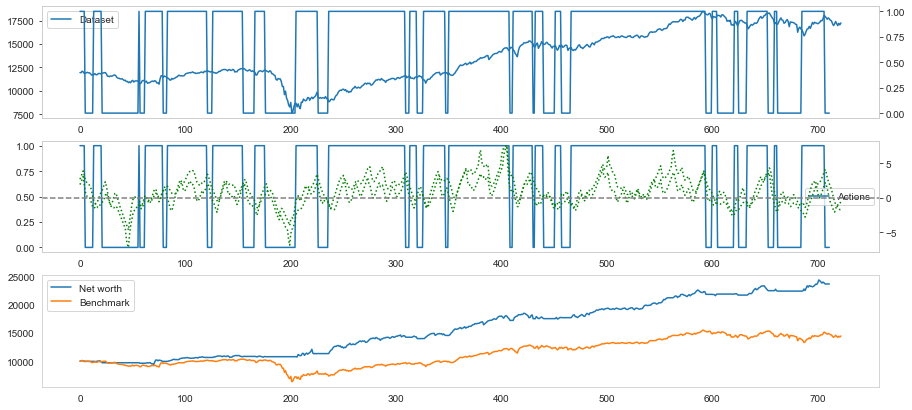

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(test_df['Close'], label='Dataset')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
ax2.plot(actions_over_time_test.flatten(), label='Actions')
ax2_copy = ax2.twinx()
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
ax2_copy.axhline(0.0, ls='--', color='grey')
ax3.plot(np.array(history_test['net_worth']), label='Net worth')
ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.plot()

In [ ]:
if __name__ == "__main__":

    running_for_the_first_time = True
    run_minute = 33

    while True:
        if ((datetime.now().minute == run_minute)) or running_for_the_first_time:
            print("Executing")
            TICKER = ".NSEI"
            INIT_NET_WORTH = 10000
            HISTORICAL_STATES = 5
            features = [
                {"feature": "Fisher20", "lookback": 20},
                {"feature": "Fisher5", "lookback": 5},
            ]
            LR = 0.001
            RANDOM_SEED = 11111
            WINDOW = max([feature["lookback"] for feature in features])
            train_percent = 0.8

            df = get_data(TICKER, 'D')
            signal_features = pd.DataFrame(index=df.index)
            for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
                if feature == "Close":
                    signal_features[feature] = df["Close"]
                if feature.startswith("Fisher"):
                    signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]

            train_df = df.iloc[:int(train_percent * len(df))].reset_index(drop=True)
            test_df = df.iloc[int(train_percent * len(df)):].reset_index(drop=True)
            train_signal_features = signal_features.iloc[:int(train_percent * len(signal_features))].reset_index(
                drop=True)
            test_signal_features = signal_features.iloc[int(train_percent * len(signal_features)):].reset_index(
                drop=True)

            N_TIME_STEPS = len(train_df) - HISTORICAL_STATES

            # The algorithms require a vectorized environment to run
            env_train = DummyVecEnv(
                [lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
            model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

            env_test = DummyVecEnv(
                [lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)

            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
            ax1.plot(test_df['Close'], label='Dataset')
            ax1_copy = ax1.twinx()
            ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
            ax2.plot(actions_over_time_test.flatten(), label='Actions')
            ax2_copy = ax2.twinx()
            for feature in [feature["feature"] for feature in features]:
                ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
            ax2_copy.axhline(0.0, ls='--', color='grey')
            ax3.plot(np.array(history_test['net_worth']), label='Net worth')
            ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.savefig(f"{TICKER}.jpg")

            temp_res = pd.DataFrame(history_test)
            text = ""
            text = f"Signal at {temp_res.iloc[-1]['datetime']} : {signal_print(temp_res.iloc[-1]['action'])}" + "\n" f"Signal at {temp_res.iloc[-2]['datetime']}: {signal_print(temp_res.iloc[-2]['action'])}" + "\n" f"Signal at {temp_res.iloc[-3]['datetime']}: {signal_print(temp_res.iloc[-3]['action'])}" + "\n" + "\n"

            if running_for_the_first_time == True:
                SendMail(TICKER, text, f"{TICKER}.jpg")
                # pass
            else:
                if (datetime.now().hour == 15):
                    SendMail(TICKER, text, f"{TICKER}.jpg")

        running_for_the_first_time = False

        print("Sleeping")

        time_now = datetime.now()
        next_run = datetime.now()
        try:
            if (datetime.now().hour == 23):
                next_run = next_run.replace(hour=0).replace(
                    minute=run_minute).replace(second=45)
            else:
                if (datetime.now().minute < run_minute):
                    next_run = next_run.replace(minute=run_minute).replace(
                        second=45)
                else:
                    next_run = next_run.replace(hour=next_run.hour + 1).replace(
                        minute=run_minute).replace(second=45)
        except:
            pass

        print(f"Supposed to wake up at : {datetime.now() + timedelta(seconds=(next_run - time_now).seconds - 30)}")
        time.sleep((next_run - time_now).seconds - 30)

        print("Woken Up")











In [ ]:
def signal_print(inp):
    if inp == 0:
        signal = "Neutral on Equity, Long on Fixed Income"
    else:
        signal = "Long on Equity, Neutral on Fixed Income"
    return signal

def SendMail(ticker, text, ImgFileName):
    msg = MIMEMultipart()
    msg['Subject'] = f'Strategy Update on RL: {ticker}'
    msg['From'] = 'algo_notifications@acsysindia.com'
    msg['Cc'] = 'suprabhashsahu@acsysindia.com, aditya@shankar.biz'  #
    msg['To'] = 'algo_notifications@acsysindia.com'

    text = MIMEText(text)
    msg.attach(text)

    with open(ImgFileName, 'rb') as f:
        img_data = f.read()
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    msg.attach(image)

    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.ehlo()
    s.starttls()
    s.ehlo()
    s.login('algo_notifications@acsysindia.com', 'esahYah8')
    s.sendmail('algo_notifications@acsysindia.com',['suprabhashsahu@acsysindia.com', 'algo_notifications@acsysindia.com', 'aditya@shankar.biz'],msg.as_string())  #
    s.quit()

class StockTradingEnv(gym.Env):

    def __init__(self, df, features, init_account_balance, window_shape, random_start=False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        self.signal_features = features

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        self.signal_features = self.signal_features.iloc[self.start:self.end]
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step - self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.current_step >= (len(self.df) - self.window_shape)):  # (self.net_worth <= 0) or
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = self.df.iloc[self.current_step]["Close"]
        self.current_price = current_price
        self.datetime = self.df.iloc[self.current_step]["Datetime"]

        if not self.in_position:
            if action == 1:  # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else:  # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1:  # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else:  # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'price': self.current_price,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance,
            'datetime': self.datetime
        }

def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': [],
        'price': [],
        'datetime': []
    }

    for i in range(len(df) - HISTORICAL_STATES):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action[0])
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])
        history['price'].append(state['price'])
        history['datetime'].append(state['datetime'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

if __name__ == "__main__":

    running_for_the_first_time = True
    run_minute = 33

    while True:
        if ((datetime.now().minute == run_minute)) or running_for_the_first_time:
            print("Executing")
            TICKER = ".NSEI"
            INIT_NET_WORTH = 10000
            HISTORICAL_STATES = 5
            features = [
                {"feature": "Fisher20", "lookback": 20},
                {"feature": "Fisher5", "lookback": 5},
            ]
            LR = 0.001
            RANDOM_SEED = 11111
            WINDOW = max([feature["lookback"] for feature in features])
            train_percent = 0.8

            df = get_data(TICKER, 'D')
            signal_features = pd.DataFrame(index=df.index)
            for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
                if feature == "Close":
                    signal_features[feature] = df["Close"]
                if feature.startswith("Fisher"):
                    signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]

            train_df = df.iloc[:int(train_percent * len(df))].reset_index(drop=True)
            test_df = df.iloc[int(train_percent * len(df)):].reset_index(drop=True)
            train_signal_features = signal_features.iloc[:int(train_percent * len(signal_features))].reset_index(
                drop=True)
            test_signal_features = signal_features.iloc[int(train_percent * len(signal_features)):].reset_index(
                drop=True)

            N_TIME_STEPS = len(train_df) - HISTORICAL_STATES

            # The algorithms require a vectorized environment to run
            env_train = DummyVecEnv(
                [lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
            model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

            env_test = DummyVecEnv(
                [lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)

            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
            ax1.plot(test_df['Close'], label='Dataset')
            ax1_copy = ax1.twinx()
            ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
            ax2.plot(actions_over_time_test.flatten(), label='Actions')
            ax2_copy = ax2.twinx()
            for feature in [feature["feature"] for feature in features]:
                ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
            ax2_copy.axhline(0.0, ls='--', color='grey')
            ax3.plot(np.array(history_test['net_worth']), label='Net worth')
            ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.savefig(f"{TICKER}.jpg")

            temp_res = pd.DataFrame(history_test)
            text = ""
            text = f"Signal at {temp_res.iloc[-1]['datetime']} : {signal_print(temp_res.iloc[-1]['action'])}" + "\n" f"Signal at {temp_res.iloc[-2]['datetime']}: {signal_print(temp_res.iloc[-2]['action'])}" + "\n" f"Signal at {temp_res.iloc[-3]['datetime']}: {signal_print(temp_res.iloc[-3]['action'])}" + "\n" + "\n"

            if running_for_the_first_time == True:
                SendMail(TICKER, text, f"{TICKER}.jpg")
                # pass
            else:
                if (datetime.now().hour == 15):
                    SendMail(TICKER, text, f"{TICKER}.jpg")

        running_for_the_first_time = False

        print("Sleeping")

        time_now = datetime.now()
        next_run = datetime.now()
        try:
            if (datetime.now().hour == 23):
                next_run = next_run.replace(hour=0).replace(
                    minute=run_minute).replace(second=45)
            else:
                if (datetime.now().minute < run_minute):
                    next_run = next_run.replace(minute=run_minute).replace(
                        second=45)
                else:
                    next_run = next_run.replace(hour=next_run.hour + 1).replace(
                        minute=run_minute).replace(second=45)
        except:
            pass

        print(f"Supposed to wake up at : {datetime.now() + timedelta(seconds=(next_run - time_now).seconds - 30)}")
        time.sleep((next_run - time_now).seconds - 30)

        print("Woken Up")











In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from Data.data_retrieval import get_data
from Utils.add_features import add_fisher
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import time
from datetime import timedelta
from datetime import date, datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
import os

def signal_print(inp):
    if inp == 0:
        signal = "Neutral on Equity, Long on Fixed Income"
    else:
        signal = "Long on Equity, Neutral on Fixed Income"
    return signal

def SendMail(ticker, text, ImgFileName):
    msg = MIMEMultipart()
    msg['Subject'] = f'Strategy Update on RL: {ticker}'
    msg['From'] = 'algo_notifications@acsysindia.com'
    msg['Cc'] = 'suprabhashsahu@acsysindia.com, aditya@shankar.biz'  #
    msg['To'] = 'algo_notifications@acsysindia.com'

    text = MIMEText(text)
    msg.attach(text)

    with open(ImgFileName, 'rb') as f:
        img_data = f.read()
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    msg.attach(image)

    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.ehlo()
    s.starttls()
    s.ehlo()
    s.login('algo_notifications@acsysindia.com', 'esahYah8')
    s.sendmail('algo_notifications@acsysindia.com',['suprabhashsahu@acsysindia.com', 'algo_notifications@acsysindia.com', 'aditya@shankar.biz'],msg.as_string())  #
    s.quit()

class StockTradingEnv(gym.Env):

    def __init__(self, df, features, init_account_balance, window_shape, random_start=False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        self.signal_features = features

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        self.signal_features = self.signal_features.iloc[self.start:self.end]
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step - self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.current_step >= (len(self.df) - self.window_shape)):  # (self.net_worth <= 0) or
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = self.df.iloc[self.current_step]["Close"]
        self.current_price = current_price
        self.datetime = self.df.iloc[self.current_step]["Datetime"]

        if not self.in_position:
            if action == 1:  # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else:  # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1:  # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else:  # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'price': self.current_price,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance,
            'datetime': self.datetime
        }

def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': [],
        'price': [],
        'datetime': []
    }

    for i in range(len(df) - HISTORICAL_STATES):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action[0])
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])
        history['price'].append(state['price'])
        history['datetime'].append(state['datetime'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

if __name__ == "__main__":

    running_for_the_first_time = True
    run_minute = 33

    while True:
        if ((datetime.now().minute == run_minute)) or running_for_the_first_time:
            print("Executing")
            TICKER = ".NSEI"
            INIT_NET_WORTH = 10000
            HISTORICAL_STATES = 5
            features = [
                {"feature": "Fisher20", "lookback": 20},
                {"feature": "Fisher5", "lookback": 5},
            ]
            LR = 0.001
            RANDOM_SEED = 11111
            WINDOW = max([feature["lookback"] for feature in features])
            train_percent = 0.8

            df = get_data(TICKER, 'D')
            signal_features = pd.DataFrame(index=df.index)
            for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
                if feature == "Close":
                    signal_features[feature] = df["Close"]
                if feature.startswith("Fisher"):
                    signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]

            train_df = df.iloc[:int(train_percent * len(df))].reset_index(drop=True)
            test_df = df.iloc[int(train_percent * len(df)):].reset_index(drop=True)
            train_signal_features = signal_features.iloc[:int(train_percent * len(signal_features))].reset_index(
                drop=True)
            test_signal_features = signal_features.iloc[int(train_percent * len(signal_features)):].reset_index(
                drop=True)

            N_TIME_STEPS = len(train_df) - HISTORICAL_STATES

            # The algorithms require a vectorized environment to run
            env_train = DummyVecEnv(
                [lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
            model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

            env_test = DummyVecEnv(
                [lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
            history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)

            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
            ax1.plot(test_df['Close'], label='Dataset')
            ax1_copy = ax1.twinx()
            ax1_copy.plot(actions_over_time_test.flatten(), label='Actions')
            ax2.plot(actions_over_time_test.flatten(), label='Actions')
            ax2_copy = ax2.twinx()
            for feature in [feature["feature"] for feature in features]:
                ax2_copy.plot(test_signal_features[feature].values, label=feature, color='green', ls='dotted')
            ax2_copy.axhline(0.0, ls='--', color='grey')
            ax3.plot(np.array(history_test['net_worth']), label='Net worth')
            ax3.plot((test_df['Close'] * INIT_NET_WORTH / test_df['Close'].iloc[0]).values, label='Benchmark')
            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.savefig(f"{TICKER}.jpg")

            temp_res = pd.DataFrame(history_test)
            text = ""
            text = f"Signal at {temp_res.iloc[-1]['datetime']} : {signal_print(temp_res.iloc[-1]['action'])}" + "\n" f"Signal at {temp_res.iloc[-2]['datetime']}: {signal_print(temp_res.iloc[-2]['action'])}" + "\n" f"Signal at {temp_res.iloc[-3]['datetime']}: {signal_print(temp_res.iloc[-3]['action'])}" + "\n" + "\n"

            if running_for_the_first_time == True:
                SendMail(TICKER, text, f"{TICKER}.jpg")
                # pass
            else:
                if (datetime.now().hour == 15):
                    SendMail(TICKER, text, f"{TICKER}.jpg")

        running_for_the_first_time = False

        print("Sleeping")

        time_now = datetime.now()
        next_run = datetime.now()
        try:
            if (datetime.now().hour == 23):
                next_run = next_run.replace(hour=0).replace(
                    minute=run_minute).replace(second=45)
            else:
                if (datetime.now().minute < run_minute):
                    next_run = next_run.replace(minute=run_minute).replace(
                        second=45)
                else:
                    next_run = next_run.replace(hour=next_run.hour + 1).replace(
                        minute=run_minute).replace(second=45)
        except:
            pass

        print(f"Supposed to wake up at : {datetime.now() + timedelta(seconds=(next_run - time_now).seconds - 30)}")
        time.sleep((next_run - time_now).seconds - 30)

        print("Woken Up")









